In this jupyter notebook we try to implement the Active Learning algorithm to find self assembling tripeptides. We start out by importing important libraries for our algorithm.

In [1]:
#importing stuff
import numpy as np                                      
import pandas as pd
import matplotlib.pyplot as plt
import math,os,random,sys,h5py
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer

The function below takes a pandas dataframe and normalizes it. 

In [2]:
def normalize_pandas_data(data):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    new_data = min_max_scaler.fit_transform(data)
    return pd.DataFrame(new_data, index=data.index, columns=data.columns)

Next we read the data from the files to use it. Since we have AP data for all peptides we use this data instead of running a simulation in each step.
Note: 'sap' is a list of all self-assembling peptides as predicted by Tuttle et al.3

In [3]:
APs = pd.read_csv("tripeptide_AP.txt", sep=": ", index_col=0, header=None, engine = 'python')              #AP scores from simulation
f = h5py.File('tripeptides.hdf5','r')                                                                      #reading data from the file generated from judred generator
peps = np.array(f.get('peptides'))
feas = np.array(f.get('features'))
data = np.array(f.get('data'))
f.close()
judp = pd.DataFrame(data, columns = feas, index = peps)                              #arranging it into a pandas data frame
logparr = np.array(judp[b'LogP WW'])
A = np.array(judp[judp[b'LogP WW']>(0)].index)
judp.drop(A,inplace=True)
judp = normalize_pandas_data(judp)
smiles = pd.read_csv("smi.txt", sep=": ", engine='python')                                                  #smiles data of peptides by their names
modp = normalize_pandas_data(pd.read_csv('Mordred_Parameters_to_be_used.csv', sep=',', engine='python'))    #mordred data in same order as the smiles data
sap = ['PHE-PHE-PHE','TRP-PHE-PHE','PHE-TRP-PHE','PHE-PHE-TRP','ILE-PHE-TRP','PHE-TYR-ILE','PRO-TRP-PHE','TRP-PHE-LEU','ILE-PHE-PHE','VAL-PHE-TRP','PRO-PHE-PHE','PHE-PHE-MET','TRP-PHE-PHE','VAL-PHE-PHE','MET-PHE-PHE','TRP-LEU-LEU','SER-PHE-TRP','ILE-MET-TRP','LEU-CYS-PHE','SER-SER-PHE','SER-CYS-TRP','LYS-TRP-PHE','LYS-PHE-TRP','LYS-TRP-ASP','LYS-HSE-ASP','TRP-LYS-ASP','HSE-LYS-ASP','LYS-TYR-ASP','LYS-PHE-ASP','LYS-TRP-GLU','TRP-LYS-GLU','LYS-GLU-HSE','LYS-TYR-GLU','LYS-HSE-GLU','PRO-CYS-PHE','THR-SER-PHE','GLY-PHE-PHE','VAL-ALA-TRP']       #list of self assenbling peptides

In [4]:
for i in range(len(A)):
    A[i] = A[i].decode(encoding='utf-8')
print(f"The peptides that are being removed {A}")
APs.drop(A,inplace=True)
APs

The peptides that are being removed ['ALA-ALA-ILE' 'ALA-ALA-LEU' 'ALA-CYS-PHE' ... 'TYR-TYR-ILE' 'TYR-TYR-LEU'
 'TYR-TYR-VAL']


,1
0,
ALA-ALA-ALA,1.648900
ASN-GLN-CYS,1.739705
ALA-ALA-CYS,2.176944
ALA-ALA-ARG,1.138715
PRO-MET-GLY,1.074714
...,...
VAL-PHE-LYS,1.695091
VAL-PRO-GLU,1.035959
VAL-SER-ALA,1.381075


In [5]:
judp

,b'SP2',b'NH2',b'MW',b'S',b'LogP WW',b'Z',b'MaxASA',b'RotRatio',b'Bulkiness',b'OH'
b'ALA-ALA-CYS',-1.0,-1.0,-0.585117,-0.333333,0.756570,0.000000,-0.575188,-1.000000,0.075128,-1.000000
b'ALA-ALA-ASP',-0.9,-1.0,-0.518254,-1.000000,0.150761,-0.333333,-0.477444,-0.916667,0.002252,-1.000000
b'ALA-ALA-GLU',-0.9,-1.0,-0.439810,-1.000000,0.372061,-0.333333,-0.364662,-0.937500,0.079632,-1.000000
b'ALA-ALA-PHE',-0.4,-1.0,-0.338761,-1.000000,0.977870,0.000000,-0.300752,-0.500000,0.334698,-1.000000
b'ALA-ALA-GLY',-1.0,-1.0,-0.842999,-1.000000,0.502075,0.000000,-0.812030,-1.000000,-0.336745,-1.000000
...,...,...,...,...,...,...,...,...,...,...
b'TYR-TYR-SER',0.2,-1.0,0.355490,-1.000000,0.781466,0.000000,0.387218,0.000000,0.446469,1.000000
b'TYR-TYR-THR',0.2,-1.0,0.433991,-1.000000,0.842324,0.000000,0.451128,-0.250000,0.704401,1.000000
b'TYR-TYR-TRP',1.0,-1.0,0.910197,-1.000000,0.939142,0.000000,0.875940,0.666667,0.945957,0.333333
b'TYR-TYR-TYR',0.8,-1.0,0.781284,-1.000000,0.809129,0.000000,0.793233,0.500000,0.796929,1.000000


In [6]:
smiles

,Peptides,smiles
0,ALA-ALA-ALA,[H]N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](C)C(O)=O
1,ALA-ALA-CYS,[H]N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CS)C(...
2,ALA-ALA-ASP,[H]N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(O)...
3,ALA-ALA-GLU,[H]N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(O...
4,ALA-ALA-PHE,[H]N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=C...
...,...,...
7995,TYR-TYR-SER,[H]N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC1=CC...
7996,TYR-TYR-THR,[H]N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC1=CC...
7997,TYR-TYR-VAL,[H]N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC1=CC...
7998,TYR-TYR-TRP,[H]N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC1=CC...


In [7]:
modp

,Unnamed: 0,AATS0s,AATS2s,AATSC0are,AATSC0s,AATSC0se,AATSC1are,AATSC1pe,AATSC1v,AATSC2s,...,NsNH2,NsssN,RotRatio,SaasC,ETA_dEpsilon_B,ETA_shape_p,ETA_shape_y,Kier3,SpMAD_A,SlogP_VSA4
0,-1.00000,-0.232323,-0.252278,0.023694,-0.020400,-0.042373,0.242472,0.224388,-0.775307,0.081151,...,-0.5,-1.0,-0.174312,-1.000000,-1.000000,0.938632,0.615206,-0.594865,-0.999740,-1.000000
1,-0.99975,-0.296009,-0.297832,-0.048211,-0.062218,-0.096375,0.298121,0.236236,-0.818339,0.054558,...,-0.5,-1.0,-0.009174,-1.000000,-1.000000,0.906403,0.232977,-0.580930,-0.753054,-1.000000
2,-0.99950,0.246914,0.224292,0.462118,0.419799,0.416672,-0.190430,-0.202021,-0.248698,0.481399,...,-0.5,-1.0,0.045872,-1.000000,-1.000000,0.708948,0.617650,-0.387127,-1.000000,-1.000000
3,-0.99925,0.077482,0.044914,0.321717,0.288771,0.280594,0.010702,-0.012467,-0.337247,0.437974,...,-0.5,-1.0,0.173346,-1.000000,-1.000000,0.587540,0.410140,-0.283539,-0.814009,-1.000000
4,-0.99900,-0.563853,-0.451082,-0.454447,-0.415300,-0.467848,0.590004,0.540307,-0.029802,-0.190107,...,-0.5,-1.0,-0.234362,-0.368639,0.015732,-0.015586,-0.042109,-0.460807,-0.194774,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.99900,-0.346334,-0.291621,-0.164071,-0.244333,-0.139386,0.167825,0.094548,0.900114,-0.468058,...,-0.5,-1.0,-0.256881,0.110087,0.631559,-0.411206,0.020975,-0.207683,0.288059,-1.000000
7996,0.99925,-0.422228,-0.347084,-0.239328,-0.309133,-0.215300,0.261171,0.187260,0.798861,-0.377276,...,-0.5,-1.0,-0.294412,0.106351,0.514444,-0.270064,0.208313,-0.176539,0.145550,-1.000000
7997,0.99950,-0.620089,-0.523298,-0.487674,-0.495633,-0.465288,0.519848,0.448797,0.525072,-0.279930,...,-0.5,-1.0,-0.294412,0.224857,0.368261,-0.225151,0.172017,-0.176539,0.145550,-0.333333
7998,0.99975,-0.708493,-0.501028,-0.642080,-0.655456,-0.613518,0.537129,0.468147,0.898086,-0.423522,...,-0.5,-1.0,-0.457405,0.770275,0.938094,-0.727992,0.044843,-0.195957,0.644368,-1.000000


In [8]:
x_train_jd = [np.array(judp.loc[b'ALA-ALA-ALA'])]                  # initializing the training data with data of polyalanine 
x_train_md = np.array(modp.iloc[smiles.index[smiles['Peptides']=='ALA-ALA-ALA']])
Y_train = np.array(APs.loc['ALA-ALA-ALA'])
print(x_train_jd)
print(x_train_md)
print(Y_train)

[array([-1.        , -1.        , -0.7644987 , -1.        ,  0.7261411 ,
        0.        , -0.7180451 , -1.        , -0.00511765, -1.        ],
      dtype=float32)]
[[-1.         -0.23232279 -0.25227758  0.02369409 -0.02040045 -0.04237275
   0.24247212  0.22438755 -0.77530704  0.08115086 -0.01563126 -0.20447343
  -0.40439627  0.47622958  0.44025033  0.58623777 -0.32309104 -0.18142378
  -0.16637574 -0.22145864  0.37904286  0.65680896 -0.25917636  0.30954229
  -0.82108838  0.0210415  -0.21213343 -0.09262765 -0.42917629 -0.84054685
   0.58948184 -0.12050473 -0.07207482 -0.63671511  0.48837209  0.48837209
  -0.5        -1.         -0.17431193 -1.         -1.          0.93863167
   0.61520551 -0.59486494 -0.99973974 -1.        ]]
[1.64890034]


The next function is a random peptide selector, it generates 10 random numbers between 1 to 8000 and uses these numbers as indices to select peptides from the data and adds it to the training set.

In [9]:
def randPepSelector(APs, judp, modp, smiles, x_train_jd, x_train_md, Y_train):                           # a is APs, b is judp/modp
    for pep in range(10):                                                                                # generates random indecies, looks up those indecies data and adds to the training data
        i = random.randrange(1,len(judp))
        p = APs.iloc[i]
        print(p.name)
        Y_train = np.append(Y_train, np.array(p), axis=0)
        x_train_jd = np.append(x_train_jd, [np.array(judp.loc[p.name.encode('utf-8')])],axis=0)
        x_train_md = np.append(x_train_md, np.array(modp.iloc[smiles.index[smiles['Peptides']==p.name]]), axis=0)
    return Y_train,x_train_jd, x_train_md  

Next we call the random peptide selector and print the data to have a look at it.

In [10]:
Y_train,x_train_jd,x_train_md = randPepSelector(APs,judp,modp,smiles,x_train_jd,x_train_md,Y_train)                 # first we take a set of random peptides(10)
print(x_train_jd)
print(x_train_md)
print(Y_train)

ARG-HSE-ILE
TRP-SER-GLN
THR-THR-CYS
VAL-THR-GLU
ALA-THR-SER
PHE-MET-ASP
SER-TYR-LYS
GLU-GLU-VAL
GLN-ALA-ARG
MET-ASP-MET
[[-1.         -1.         -0.7644987  -1.          0.7261411   0.
  -0.7180451  -1.         -0.00511765 -1.        ]
 [-0.6        -0.3333333   0.31671572 -1.          0.9640387   0.33333334
   0.43984962 -0.875       0.60368466 -1.        ]
 [-0.09999996 -0.6666666   0.2883482  -1.          0.92254496  0.
   0.3270676  -0.4375      0.44892538 -0.3333333 ]
 [-1.         -1.         -0.24918163 -0.3333333   0.87828493  0.
  -0.2518797  -1.          0.42476976  0.33333337]
 [-0.9        -1.         -0.11489713 -1.          0.670816   -0.33333334
  -0.0338347  -0.96428573  0.66673493 -0.3333333 ]
 [-1.         -1.         -0.50706387 -1.          0.7869986   0.
  -0.45864666 -1.          0.08659172  0.33333337]
 [-0.3        -1.          0.24381042 -0.3333333   0.61549103 -0.33333334
   0.29699254 -0.65        0.5365405  -1.        ]
 [-0.39999998 -0.6666666   0.15965891

In [11]:
def loc(s,Y_pred):                      #takes the APs of top peptides and returns their location in judred parameters so we can look up their names by their location
    y = []
    for i in range(len(s)):
        for j in range(len(Y_pred)):
            if s[i] == Y_pred[j]:
                if j not in y:
                    y.append(j)
    return y

The next function, takes in training data(judred parameters and AP scores) and trains a SVM. The hyperparameters for this model are given in the supporting information of the paper. Then it predicts the AP score for all peptides using the judred data. We then return the names of the top 1207 peptides which are predicted. The number 1207 comes from the formula given in the paper.   

In [12]:
# Block-1

def topN(n,judp,x_train_jd,Y_train,y_nam):                                                            #takes the judred parameters and the training data 
    imputer = SimpleImputer(strategy='constant')                                                    #imputer removes NaN values from the data set
    x_train_jd = imputer.fit_transform(x_train_jd)
    svr = SVR(kernel='rbf',gamma='scale',C=100,epsilon=0.1,max_iter=-1,tol=0.0001,verbose=0)    #trains a svm(rbf)
    svr.fit(x_train_jd,Y_train)
    judp.drop(y_nam,axis=0,inplace=True)
    x_test = []
    for i in range(len(judp)):
        #if True in np.isnan(np.array(judp.iloc[i])):
            #print(i)    
        x_test.append(np.array(judp.iloc[i]))
    imputer = SimpleImputer(strategy='mean')                                                    #imputer removes NaN values from the data set
    x_imputed = imputer.fit_transform(x_test)
    Y_pred = svr.predict(x_imputed)                                                             #predicts AP scores for all peptides
    s = sorted(Y_pred)
    s = s[len(judp)-n:]
    y_loc = loc(s,Y_pred)
    y_nam = ['']*len(y_loc)
    for i in range(len(y_loc)):
        y_nam[i] = judp.iloc[y_loc[i]].name
    return y_nam   

This function takes the names of the predicted peptides, looks the data up using the name and adds it the training data.

In [13]:
# Block-2

def addToTrain(y_nam,APs,judp,modp,x_train_jd,x_train_md,Y_train):                                              #takes the predicted peptide in previous iteration and adds them to training data
    for i in y_nam:
        if np.array(APs.loc[i.decode(encoding='utf-8')]) not in Y_train:
            x_train_jd = np.append(x_train_jd, [np.array(judp.loc[i])], axis=0)
            x_train_md = np.append(x_train_md, np.array(modp.iloc[smiles.index[smiles['Peptides']==i.decode(encoding='utf-8')]]), axis=0)
            Y_train = np.append(Y_train, np.array(APs.loc[i.decode(encoding='utf-8')]), axis=0)
    return x_train_jd,x_train_md,Y_train

This function trains a svm on the mordred data of the peptides in training dataset and gives the names of the predicted peptides.

In [14]:
# Block-3

def topn(n,smiles, modp, y_nam_jd, x_train_md, Y_train):
    svr = SVR(kernel='rbf',gamma='scale',C=30,epsilon=0.1,max_iter=-1,tol=0.0001,verbose=0)    #trains a svm(rbf)
    svr.fit(x_train_md,Y_train)
    x = np.empty_like([np.array(modp.iloc[1])])
    for i in y_nam_jd:
        x = np.append(x, np.array(modp.iloc[smiles.index[smiles['Peptides']==i.decode(encoding='utf-8')]]), axis=0)
    x = np.delete(x,0,0)
    Y_pred = svr.predict(x)                                                                     #predicts AP scores for all peptides
    pred = pd.DataFrame(data=Y_pred, index=y_nam_jd, columns=['prediction'])
    y_nam = np.array(pred['prediction'].nlargest(n=n).index)
    return y_nam, pred


This function identifies if a peptide present in 'sap' the list of self assembling peptides.

In [15]:
def pepidentifier(y_nam,sap,a,q):
    for j in y_nam:
        b = j.decode(encoding='utf-8')
        for i in sap:            
            if b == i:
                print(b+' which is a self assembling peptide is predicted in the ' + str(q)+'th iteration')
                a.append(b)
    return a

Next we run the active learning algorithm, using the functions defined above. In step 1, block 1 is called. In step 2, block 3 is called. In step 3, block 2 is called.

In [16]:
def runAL(num_iter,APs,judp,smiles,modp,x_train_jd,x_train_md,Y_train,sap):
    a = []                                                                                            #array to keep track if any self-assembling peptide is found
    y_nam = []
    b = []                                                                                           #array to keep track if any self-assembling peptide is found
    r = []
    ind = []
    aap = []
    pap = []
    aap1 = []
    pap1 = []
    aap2 = []
    pap2 = []
    c = 0
    for i in range(num_iter):                                                                         #a for loop is for the number of iterations as given in input
        y_nam_jd = topN(math.ceil((np.log(3)**2) * 1000),judp,x_train_jd,Y_train,y_nam)                     #Step 1: we get the names of top 1207 peptides which are predicted by judred model by calling the function 'topN'
        y_nam, pred= topn(10,smiles, modp, y_nam_jd, x_train_md, Y_train)                                   #Step 2: from the peptides predicted by judred model we predict the top 10 AP scoring peptides as predicted by the mordred model
        print(y_nam)
        p = []
        for j in y_nam:
            jr = j.decode(encoding='utf-8')
            p.append((np.array(APs.loc[jr])-np.array(pred.loc[j]))**2)
            if c%10 == 0:
                aap = np.append(aap,np.array(APs.loc[jr]),axis=0)
                pap = np.append(pap,np.array(pred.loc[j]),axis=0)
            if c%10 == 4:
                aap1 = np.append(aap,np.array(APs.loc[jr]),axis=0)
                pap1 = np.append(pap,np.array(pred.loc[j]),axis=0)
            if c%10 == 8:
                aap2 = np.append(aap,np.array(APs.loc[jr]),axis=0)
                pap2 = np.append(pap,np.array(pred.loc[j]),axis=0)
            if jr not in b:
                b.append(jr)
        c += 1
        x = math.sqrt(sum(p)/10)
        r.append(x)
        ind.append(i)
        a = pepidentifier(y_nam,sap,a,i)                                                                #we call the peptide identifier function which checks if any self-assembling peptide is predicted.
        x_train_jd,x_train_md,Y_train = addToTrain(y_nam,APs,judp,modp,x_train_jd,x_train_md,Y_train) #Step 3: we add the top 10 peptides to the training set.
    print(a)
    print(len(a))
    return topn(40,smiles, modp, y_nam_jd, x_train_md, Y_train),a,b,r,ind,aap,pap,aap1,pap1,aap2,pap2                                        #after the last iteration we print the top 40 peptides predicted by the mordred model.

y_nam,a,b,r,ind,aap,pap,aap1,pap1,aap2,pap2 = runAL(100,APs,judp,smiles,modp,x_train_jd,x_train_md,Y_train,sap)                              #we run the active learning process for 100 iteration.
print(y_nam)

[b'THR-CYS-SER' b'SER-CYS-THR' b'SER-CYS-CYS' b'THR-SER-CYS'
 b'SER-THR-CYS' b'SER-CYS-SER' b'THR-CYS-CYS' b'SER-SER-CYS'
 b'CYS-SER-THR' b'CYS-CYS-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-SER-CYS' b'CYS-CYS-THR' b'CYS-THR-CYS' b'CYS-THR-SER'
 b'CYS-SER-SER' b'GLY-CYS-THR' b'PRO-CYS-SER' b'GLY-CYS-SER'
 b'GLY-SER-CYS' b'PRO-SER-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-MET-SER' b'CYS-THR-THR' b'CYS-PRO-SER' b'CYS-PRO-THR'
 b'CYS-ALA-SER' b'CYS-GLY-THR' b'CYS-SER-MET' b'CYS-SER-PRO'
 b'CYS-THR-PRO' b'CYS-ALA-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-CYS-CYS' b'CYS-CYS-PRO' b'CYS-PRO-CYS' b'SER-SER-SER'
 b'GLY-SER-SER' b'SER-SER-THR' b'SER-THR-SER' b'THR-SER-SER'
 b'SER-PRO-SER' b'THR-CYS-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-CYS-CYS' b'CYS-MET-CYS' b'CYS-ALA-PRO' b'GLY-CYS-PRO'
 b'CYS-LYS-CYS' b'GLY-PRO-CYS' b'ALA-PRO-THR' b'CYS-CYS-LYS'
 b'CYS-GLY-PRO' b'SER-SER-PRO']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-PRO-CYS' b'ALA-PRO-SER' b'CYS-PRO-ALA' b'ALA-CYS-PRO'
 b'CYS-TYR-PRO' b'CYS-TRP-THR' b'CYS-PRO-TYR' b'ALA-THR-THR'
 b'GLY-PRO-PRO' b'CYS-TRP-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-PRO-GLY' b'GLU-PRO-PRO' b'ALA-ALA-PRO' b'ALA-CYS-VAL'
 b'SER-TRP-SER' b'THR-THR-SER' b'THR-THR-THR' b'CYS-SER-TRP'
 b'SER-THR-THR' b'TRP-SER-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-THR-TRP' b'THR-SER-THR' b'THR-TRP-SER' b'SER-TRP-THR'
 b'PHE-SER-SER' b'ALA-TRP-THR' b'GLY-TRP-SER' b'HSE-TRP-SER'
 b'GLY-TRP-THR' b'ALA-TRP-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-TRP-PRO' b'GLY-PRO-TRP' b'HSE-SER-TRP' b'GLY-SER-TRP'
 b'ALA-SER-TRP' b'ALA-THR-TRP' b'SER-SER-TRP' b'GLY-THR-TRP'
 b'THR-SER-TRP' b'TRP-SER-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-THR-TRP' b'CYS-TRP-CYS' b'CYS-CYS-TRP' b'CYS-ALA-TRP'
 b'TRP-THR-SER' b'ALA-HSE-TRP' b'GLY-TRP-TRP' b'ALA-TRP-CYS'
 b'ALA-CYS-TRP' b'CYS-TRP-ALA']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-GLY-TRP' b'CYS-TRP-GLY' b'GLY-CYS-TRP' b'GLY-TRP-CYS'
 b'ALA-TRP-HSE' b'CYS-LYS-TRP' b'CYS-TRP-LYS' b'LYS-TRP-TRP'
 b'CYS-TYR-TRP' b'CYS-TRP-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ASP-TRP-THR' b'CYS-TYR-THR' b'ASP-TRP-TRP' b'SER-CYS-TRP'
 b'TRP-CYS-SER' b'SER-TRP-CYS' b'PHE-GLY-PRO' b'ASP-THR-TRP'
 b'ASP-TRP-SER' b'GLY-HSE-PRO']
SER-CYS-TRP which is a self assembling peptide is predicted in the 11th iteration


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-PHE-PRO' b'GLY-PRO-PHE' b'TRP-GLY-PRO' b'PHE-PRO-GLY'
 b'CYS-TYR-CYS' b'CYS-CYS-TYR' b'GLY-PHE-CYS' b'GLY-ALA-TRP'
 b'GLY-PHE-THR' b'PRO-GLY-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-GLY-TRP' b'TRP-GLY-TRP' b'PHE-GLY-TRP' b'GLY-TRP-ALA'
 b'GLY-TRP-PHE' b'GLY-PHE-TRP' b'GLY-TRP-GLY' b'TRP-TRP-GLY'
 b'PHE-ALA-SER' b'GLY-CYS-PHE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'PHE-TRP-GLY' b'CYS-TYR-SER' b'GLU-TRP-TRP' b'ALA-TYR-TRP'
 b'ALA-GLY-TRP' b'ALA-ALA-TRP' b'CYS-THR-TYR' b'ALA-TRP-TYR'
 b'ALA-CYS-CYS' b'CYS-SER-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-TYR-SER' b'SER-TYR-THR' b'THR-TYR-SER' b'THR-TYR-THR'
 b'SER-SER-TYR' b'SER-THR-TYR' b'SER-TYR-CYS' b'SER-PHE-SER'
 b'THR-SER-TYR' b'CYS-ALA-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-TYR-THR' b'GLY-TYR-THR' b'GLY-TYR-SER' b'THR-THR-TYR'
 b'SER-CYS-TYR' b'GLY-PRO-TYR' b'GLY-TYR-CYS' b'TYR-SER-SER'
 b'ALA-TRP-ALA' b'GLY-CYS-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-THR-SER' b'TYR-SER-THR' b'TYR-ASP-SER' b'SER-ASP-TYR'
 b'TYR-CYS-SER' b'TYR-THR-THR' b'SER-SER-PHE' b'THR-TYR-CYS'
 b'SER-TYR-ASP' b'THR-HSE-SER']
SER-SER-PHE which is a self assembling peptide is predicted in the 17th iteration


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-HSE-SER' b'GLY-PRO-THR' b'SER-HSE-THR' b'SER-SER-HSE'
 b'ALA-PRO-TYR' b'TYR-SER-CYS' b'ALA-TRP-GLY' b'THR-CYS-TYR'
 b'GLY-SER-TYR' b'ALA-CYS-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-TYR-PRO' b'THR-HSE-THR' b'GLY-TYR-PRO' b'HSE-THR-THR'
 b'GLY-PRO-SER' b'CYS-ALA-VAL' b'CYS-CYS-ALA' b'TYR-CYS-THR'
 b'GLY-THR-TYR' b'CYS-GLY-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-GLY-ILE' b'CYS-GLY-VAL' b'SER-HSE-CYS' b'TYR-THR-CYS'
 b'ALA-VAL-CYS' b'CYS-VAL-ALA' b'TYR-CYS-CYS' b'SER-CYS-HSE'
 b'CYS-SER-VAL' b'TRP-SER-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-MET-SER' b'TYR-MET-CYS' b'TYR-SER-MET' b'TYR-CYS-MET'
 b'CYS-MET-TYR' b'SER-TYR-MET' b'CYS-TYR-MET' b'SER-MET-TYR'
 b'TRP-CYS-CYS' b'TRP-PRO-GLY']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'THR-TRP-CYS' b'TRP-GLY-PHE' b'THR-CYS-TRP' b'HSE-SER-THR'
 b'GLY-TRP-VAL' b'TRP-CYS-THR' b'GLY-CYS-ILE' b'SER-PRO-TYR'
 b'PRO-TYR-THR' b'TYR-TYR-MET']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-PRO-SER' b'SER-TYR-PRO' b'TYR-TYR-PRO' b'TYR-PRO-TYR'
 b'TYR-SER-PRO' b'GLY-ILE-CYS' b'TYR-PRO-THR' b'THR-PRO-TYR'
 b'TRP-PHE-GLY' b'THR-TYR-PRO']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-THR-PRO' b'TYR-GLY-PRO' b'TYR-CYS-PRO' b'CYS-HSE-SER'
 b'TYR-TYR-CYS' b'TYR-ALA-PRO' b'TYR-PRO-CYS' b'HSE-CYS-SER'
 b'CYS-HSE-THR' b'TYR-TYR-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-CYS-TYR' b'TYR-MET-TYR' b'TYR-TYR-TYR' b'TYR-TYR-SER'
 b'SER-TYR-TYR' b'TYR-TYR-GLY' b'TYR-SER-TYR' b'THR-TYR-TYR'
 b'TYR-GLY-PHE' b'TYR-TRP-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TRP-TYR-CYS' b'TYR-CYS-TRP' b'TYR-PHE-GLY' b'TYR-PRO-ALA'
 b'TYR-HSE-CYS' b'TYR-PRO-GLY' b'TYR-HSE-THR' b'TYR-PHE-ARG'
 b'TYR-TRP-THR' b'TYR-PHE-LYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-THR-TYR' b'TRP-TYR-THR' b'TYR-TYR-TRP' b'PRO-TYR-TYR'
 b'TYR-TRP-TYR' b'THR-TYR-TRP' b'THR-TRP-TYR' b'TRP-TYR-TYR'
 b'TRP-CYS-TYR' b'TYR-TRP-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'PRO-TYR-CYS' b'TRP-LYS-PRO' b'THR-HSE-TYR' b'PRO-TYR-SER'
 b'HSE-THR-SER' b'PRO-THR-TYR' b'TRP-PRO-LYS' b'PRO-CYS-TYR'
 b'TYR-THR-TRP' b'TYR-HSE-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'PRO-GLY-PHE' b'PRO-SER-TYR' b'PRO-PHE-GLY' b'PRO-ALA-TYR'
 b'PRO-TRP-GLY' b'PRO-TYR-ALA' b'TYR-TYR-ALA' b'TRP-THR-CYS'
 b'PRO-GLY-TYR' b'GLY-TRP-ILE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TRP-ALA-CYS' b'TRP-ALA-THR' b'TRP-GLY-VAL' b'TRP-THR-TYR'
 b'TYR-ALA-MET' b'TYR-TRP-ALA' b'TRP-CYS-ALA' b'PRO-TYR-GLY'
 b'TYR-ALA-TRP' b'TRP-THR-ALA']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TRP-TYR-ALA' b'TRP-ALA-TYR' b'TYR-ALA-VAL' b'TYR-ALA-TYR'
 b'TYR-SER-VAL' b'TYR-TRP-GLY' b'TRP-GLY-ILE' b'VAL-GLY-TRP'
 b'TRP-TRP-LYS' b'TYR-GLY-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-VAL-SER' b'TYR-GLY-VAL' b'TYR-VAL-ALA' b'TRP-VAL-GLY'
 b'TYR-GLY-TYR' b'THR-TRP-ALA' b'THR-ALA-TRP' b'TYR-ALA-THR'
 b'SER-TYR-VAL' b'TYR-THR-HSE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-GLY-THR' b'TRP-GLY-THR' b'TRP-GLY-TYR' b'TYR-ALA-CYS'
 b'TYR-GLY-ILE' b'VAL-TRP-GLY' b'VAL-TYR-SER' b'GLY-CYS-VAL'
 b'CYS-ALA-MET' b'THR-SER-HSE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-CYS-ALA' b'TYR-GLY-CYS' b'VAL-ALA-TYR' b'VAL-SER-TYR'
 b'VAL-TYR-ALA' b'VAL-GLY-TYR' b'TYR-ALA-SER' b'TYR-THR-ALA'
 b'TYR-MET-ALA' b'TYR-GLY-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-SER-ALA' b'SER-VAL-TYR' b'THR-ALA-TYR' b'TRP-ALA-SER'
 b'TYR-ALA-ALA' b'THR-GLY-TRP' b'THR-TYR-ALA' b'ALA-TYR-VAL'
 b'VAL-GLY-PHE' b'ILE-GLY-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ILE-GLY-TYR' b'SER-THR-HSE' b'GLY-TRP-TYR' b'TYR-GLY-MET'
 b'GLY-TYR-TRP' b'PHE-GLY-VAL' b'GLY-VAL-TRP' b'TRP-TYR-GLY'
 b'THR-TYR-HSE' b'TRP-TYR-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-PHE-VAL' b'ALA-VAL-TYR' b'GLY-TYR-VAL' b'GLY-TYR-ILE'
 b'TYR-ILE-GLY' b'PHE-VAL-GLY' b'MET-SER-THR' b'THR-THR-CYS'
 b'ALA-CYS-MET' b'GLY-VAL-PHE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-ILE-TYR' b'GLY-VAL-TYR' b'ILE-TYR-GLY' b'PHE-LYS-VAL'
 b'GLY-PHE-MET' b'VAL-PHE-GLY' b'MET-TYR-CYS' b'TRP-SER-ALA'
 b'PHE-VAL-LYS' b'TYR-SER-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-PHE-GLY' b'TYR-VAL-GLY' b'THR-HSE-CYS' b'PHE-GLY-CYS'
 b'CYS-GLY-PHE' b'ALA-ALA-VAL' b'TRP-ALA-ALA' b'ALA-ALA-PHE'
 b'MET-SER-SER' b'GLY-PHE-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-PHE-ALA' b'GLY-TYR-PHE' b'PHE-ALA-ALA' b'ALA-PHE-GLY'
 b'ALA-GLY-PHE' b'GLY-ALA-PHE' b'PHE-CYS-GLY' b'PHE-TYR-GLY'
 b'PHE-GLY-TYR' b'GLY-PHE-ALA']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-TYR-TYR' b'ASP-PHE-PHE' b'GLY-GLY-PHE' b'PHE-GLY-MET'
 b'GLY-MET-PHE' b'SER-MET-SER' b'GLY-PHE-SER' b'CYS-ALA-TYR'
 b'GLY-SER-PHE' b'CYS-TYR-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-CYS-TYR' b'PHE-MET-GLY' b'PHE-GLY-ALA' b'GLY-TRP-MET'
 b'ALA-ALA-TYR' b'GLY-MET-TRP' b'ALA-TYR-CYS' b'CYS-TYR-ALA'
 b'ALA-TYR-TYR' b'ALA-PHE-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-SER-TYR' b'ALA-TYR-SER' b'ALA-SER-PHE' b'ALA-TYR-MET'
 b'ALA-MET-TYR' b'ALA-THR-TYR' b'ASP-TYR-TYR' b'ALA-GLY-TYR'
 b'VAL-TYR-GLY' b'PHE-ALA-GLY']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-TYR-ALA' b'CYS-GLY-TYR' b'GLY-ALA-TYR' b'ASP-GLY-TRP'
 b'MET-GLY-PHE' b'TRP-GLY-MET' b'ASP-ALA-TRP' b'MET-THR-SER'
 b'ASP-PHE-TYR' b'LEU-GLY-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'MET-PHE-GLY' b'MET-GLY-TRP' b'TRP-GLY-LEU' b'SER-MET-THR'
 b'GLY-LEU-TYR' b'GLY-LEU-TRP' b'GLY-GLY-TYR' b'PRO-SER-THR'
 b'LEU-GLY-TYR' b'GLY-TRP-LEU']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-TYR-LEU' b'LEU-TRP-GLY' b'TRP-LEU-GLY' b'MET-CYS-TYR'
 b'TYR-GLY-LEU' b'GLY-SER-PRO' b'MET-TYR-TYR' b'SER-TYR-TRP'
 b'SER-TRP-TYR' b'TRP-MET-GLY']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-LEU-GLY' b'LEU-TYR-GLY' b'MET-TRP-GLY' b'TRP-GLY-CYS'
 b'THR-GLY-TYR' b'SER-ALA-TYR' b'TRP-ILE-GLY' b'TRP-SER-TYR'
 b'ALA-MET-CYS' b'GLY-HSE-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-GLY-TRP' b'TRP-CYS-GLY' b'TRP-GLY-SER' b'SER-ALA-TRP'
 b'TRP-GLY-ALA' b'SER-TYR-ALA' b'TYR-HSE-TYR' b'GLY-TYR-ALA'
 b'THR-TRP-GLY' b'TYR-TYR-HSE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-TRP-ALA' b'MET-TYR-SER' b'ASP-TYR-PHE' b'LYS-SER-SER'
 b'HSE-TYR-TYR' b'SER-PRO-THR' b'TRP-THR-GLY' b'GLY-PRO-HSE'
 b'TYR-GLY-ALA' b'THR-PRO-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'HSE-GLY-TRP' b'GLY-THR-THR' b'GLY-SER-THR' b'ALA-SER-PRO'
 b'GLY-THR-PHE' b'MET-ALA-TYR' b'MET-SER-TYR' b'CYS-VAL-SER'
 b'GLY-TRP-HSE' b'SER-GLY-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'HSE-TYR-THR' b'ALA-HSE-TYR' b'HSE-CYS-THR' b'THR-CYS-HSE'
 b'ALA-THR-PRO' b'PHE-SER-ALA' b'HSE-THR-TYR' b'TRP-PHE-LYS'
 b'TYR-LYS-PHE' b'SER-ALA-PHE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'THR-GLY-PHE' b'ALA-TYR-HSE' b'SER-PHE-ALA' b'CYS-HSE-TYR'
 b'SER-GLY-PHE' b'HSE-SER-TYR' b'HSE-TYR-SER' b'HSE-SER-CYS'
 b'CYS-HSE-CYS' b'CYS-TYR-HSE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-CYS-HSE' b'HSE-CYS-CYS' b'CYS-SER-HSE' b'HSE-GLY-PRO'
 b'HSE-ALA-TYR' b'THR-ALA-THR' b'GLY-THR-PRO' b'PHE-GLY-SER'
 b'MET-CYS-SER' b'PRO-THR-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-THR-PRO' b'ILE-TRP-GLY' b'THR-PHE-GLY' b'PHE-TRP-LYS'
 b'HSE-THR-CYS' b'MET-TYR-ALA' b'GLY-ILE-TRP' b'HSE-SER-SER'
 b'THR-THR-HSE' b'PHE-LYS-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'PHE-PHE-LYS' b'PHE-LYS-PHE' b'LYS-PHE-TRP' b'LYS-TRP-PHE'
 b'LYS-PHE-PHE' b'GLY-PHE-GLY' b'HSE-GLY-TYR' b'GLY-MET-TYR'
 b'GLY-TYR-MET' b'CYS-THR-HSE']
LYS-PHE-TRP which is a self assembling peptide is predicted in the 55th iteration
LYS-TRP-PHE which is a self assembling peptide is predicted in the 55th iteration


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'MET-GLY-TYR' b'ASP-PHE-MET' b'ASP-SER-TRP' b'PHE-GLU-TYR'
 b'GLU-TYR-TYR' b'PHE-GLU-PHE' b'PHE-ARG-TRP' b'TRP-ARG-LEU'
 b'LEU-ARG-TRP' b'PHE-TRP-ARG']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'MET-TYR-GLY' b'PHE-TYR-ASP' b'PHE-TYR-ASN' b'CYS-TYR-GLY'
 b'ALA-TYR-GLY' b'TYR-SER-ASP' b'MET-ASP-ASP' b'TYR-ASN-SER'
 b'TYR-SER-ASN' b'TYR-CYS-GLY']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'PHE-ASN-TYR' b'TRP-ALA-GLY' b'ASN-TYR-TYR' b'HSE-CYS-TYR'
 b'HSE-HSE-TYR' b'PHE-SER-GLY' b'HSE-TYR-ALA' b'TRP-PHE-ARG'
 b'MET-MET-ASP' b'TYR-ARG-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TYR-TYR-ASN' b'TYR-ASN-TYR' b'TYR-TYR-ASP' b'TRP-LEU-ARG'
 b'TYR-THR-ASN' b'TYR-THR-ASP' b'ASN-TYR-SER' b'TYR-ASP-TYR'
 b'SER-THR-MET' b'PHE-GLY-HSE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-TYR-ASN' b'TYR-ASN-THR' b'SER-SER-MET' b'ASN-SER-TYR'
 b'ASN-TRP-SER' b'PRO-CYS-THR' b'ASP-TRP-TYR' b'PHE-GLY-THR'
 b'GLY-VAL-CYS' b'ASN-SER-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-ASN-TYR' b'THR-TYR-ASN' b'GLY-MET-VAL' b'GLN-TYR-SER'
 b'ARG-TYR-SER' b'SER-ASN-SER' b'PRO-LYS-PHE' b'THR-TYR-ASP'
 b'TRP-LYS-PHE' b'THR-SER-PRO']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-VAL-MET' b'GLY-LEU-MET' b'GLY-MET-MET' b'MET-GLY-VAL'
 b'LEU-GLY-MET' b'ALA-LYS-TRP' b'GLY-MET-LEU' b'THR-CYS-PRO'
 b'GLY-MET-PRO' b'THR-ASN-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'VAL-GLY-MET' b'MET-ALA-THR' b'MET-GLY-LEU' b'MET-VAL-GLY'
 b'GLY-PRO-MET' b'LEU-MET-GLY' b'VAL-MET-GLY' b'ILE-GLY-CYS'
 b'ALA-MET-THR' b'MET-ALA-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'MET-GLY-PRO' b'ALA-ALA-MET' b'PRO-GLY-PRO' b'MET-GLY-MET'
 b'SER-CYS-PRO' b'ILE-GLY-PRO' b'PRO-GLY-ILE' b'GLY-ALA-CYS'
 b'ILE-GLY-THR' b'CYS-GLY-MET']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'PRO-GLY-VAL' b'GLY-PRO-ILE' b'GLY-PRO-VAL' b'PRO-GLY-LEU'
 b'SER-CYS-VAL' b'LEU-GLY-PRO' b'GLY-ALA-ILE' b'PRO-PHE-LYS'
 b'ASP-TYR-TRP' b'PRO-ALA-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-ILE-PRO' b'GLY-ILE-THR' b'GLY-THR-ILE' b'GLY-LEU-PRO'
 b'GLY-VAL-PRO' b'GLY-PRO-LEU' b'ALA-GLY-ILE' b'LYS-PRO-PRO'
 b'GLY-SER-ILE' b'THR-GLY-ILE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ILE-PRO-GLY' b'GLY-ALA-LEU' b'CYS-GLY-LEU' b'GLY-ILE-SER'
 b'GLY-GLY-ILE' b'CYS-HSE-HSE' b'GLY-ILE-ALA' b'LEU-GLY-CYS'
 b'GLY-LEU-THR' b'ILE-GLY-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'LEU-GLY-THR' b'GLY-CYS-LEU' b'VAL-CYS-SER' b'MET-SER-CYS'
 b'THR-TYR-GLY' b'ARG-SER-TYR' b'GLN-SER-TYR' b'ALA-ALA-CYS'
 b'TYR-THR-GLY' b'GLY-THR-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-LEU-CYS' b'GLY-THR-LEU' b'GLY-LEU-SER' b'ALA-CYS-ALA'
 b'CYS-ALA-ALA' b'MET-CYS-CYS' b'SER-CYS-MET' b'GLY-SER-LEU'
 b'SER-MET-CYS' b'TYR-GLN-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'PRO-THR-CYS' b'MET-CYS-ALA' b'SER-PRO-CYS' b'SER-VAL-CYS'
 b'MET-ALA-SER' b'TYR-SER-GLN' b'HSE-TYR-CYS' b'SER-TYR-GLN'
 b'MET-GLY-THR' b'GLY-VAL-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'THR-PRO-CYS' b'SER-VAL-SER' b'SER-SER-VAL' b'GLY-THR-VAL'
 b'PRO-CYS-CYS' b'MET-GLY-CYS' b'SER-ARG-SER' b'SER-ARG-THR'
 b'HSE-GLY-PHE' b'PRO-ALA-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'LEU-PRO-GLY' b'HSE-TYR-HSE' b'ALA-TRP-LYS' b'THR-ALA-PRO'
 b'GLN-TYR-ASP' b'ALA-TRP-ASP' b'ALA-TYR-ASN' b'LYS-SER-THR'
 b'CYS-MET-ALA' b'SER-PHE-GLY']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'THR-PRO-ALA' b'VAL-GLY-PRO' b'SER-ALA-PRO' b'PRO-LYS-TRP'
 b'TYR-CYS-HSE' b'PHE-THR-GLY' b'GLY-LYS-TRP' b'PHE-PHE-ASP'
 b'HSE-HSE-CYS' b'THR-GLY-LEU']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'THR-GLY-PRO' b'SER-GLY-LEU' b'LEU-GLY-SER' b'LEU-CYS-GLY'
 b'SER-GLY-PRO' b'HSE-CYS-HSE' b'SER-ASN-THR' b'HSE-HSE-SER'
 b'THR-GLY-MET' b'TYR-ALA-HSE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-GLU-SER' b'GLY-CYS-MET' b'TYR-HSE-ALA' b'SER-SER-GLU'
 b'PRO-TRP-LYS' b'SER-ALA-VAL' b'SER-SER-ASN' b'ALA-SER-VAL'
 b'TYR-MET-GLY' b'HSE-ALA-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-MET-CYS' b'ALA-VAL-SER' b'ALA-ALA-THR' b'LEU-THR-GLY'
 b'ALA-SER-THR' b'THR-LEU-GLY' b'GLY-MET-THR' b'TYR-ASN-PHE'
 b'GLY-HSE-PHE' b'ILE-CYS-GLY']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-PHE-HSE' b'PHE-HSE-GLY' b'HSE-PHE-GLY' b'GLY-MET-SER'
 b'GLY-SER-MET' b'GLY-HSE-TYR' b'GLY-HSE-CYS' b'GLY-TYR-HSE'
 b'SER-ASN-LEU' b'MET-TYR-ASN']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-CYS-HSE' b'GLY-HSE-SER' b'GLY-HSE-MET' b'GLY-SER-HSE'
 b'TYR-ASN-ASN' b'ASN-TYR-ASN' b'GLY-THR-MET' b'ALA-ARG-TRP'
 b'ALA-THR-CYS' b'GLY-HSE-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-THR-SER' b'CYS-THR-ALA' b'ALA-THR-ALA' b'MET-TYR-ASP'
 b'GLN-TYR-TYR' b'GLY-TYR-ASN' b'ALA-CYS-SER' b'TRP-ASN-SER'
 b'TRP-ASN-THR' b'ASP-CYS-MET']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-SER-CYS' b'THR-ASN-TRP' b'CYS-CYS-GLY' b'THR-TRP-ASN'
 b'TYR-ASN-TRP' b'TRP-ASN-TYR' b'TRP-THR-ASN' b'SER-ASN-TRP'
 b'GLN-TYR-THR' b'TRP-ARG-VAL']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TRP-THR-ASP' b'THR-TRP-ASP' b'TRP-SER-ASN' b'TRP-TYR-ASN'
 b'ALA-SER-SER' b'SER-TRP-ASN' b'GLN-THR-TYR' b'TYR-TRP-ASN'
 b'CYS-SER-GLY' b'TRP-ASP-THR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLN-TRP-SER' b'SER-TRP-GLY' b'TRP-SER-GLY' b'GLN-SER-TRP'
 b'CYS-SER-ALA' b'GLY-SER-VAL' b'TRP-ASP-SER' b'SER-TYR-HSE'
 b'ASN-TYR-TRP' b'TYR-PHE-ASN']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-TRP-ASP' b'TYR-PHE-ASP' b'SER-HSE-TYR' b'TRP-GLN-SER'
 b'PHE-ASP-TYR' b'ALA-HSE-SER' b'SER-TYR-GLY' b'TYR-SER-GLY'
 b'TYR-SER-HSE' b'TRP-SER-ASP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'TRP-SER-GLN' b'SER-ASP-TRP' b'TRP-LYS-TRP' b'PHE-TRP-ASP'
 b'ARG-LEU-TRP' b'GLY-THR-SER' b'TYR-ASP-PHE' b'GLY-TRP-LYS'
 b'TRP-ARG-PHE' b'ASN-TYR-PHE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'LEU-TYR-ASP' b'TYR-LEU-ASP' b'TYR-ASP-LEU' b'TRP-ARG-THR'
 b'TRP-ARG-SER' b'LYS-TRP-SER' b'ASN-PHE-TYR' b'HSE-TRP-ALA'
 b'THR-ASN-SER' b'ALA-ASP-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ARG-TRP-SER' b'VAL-ARG-TRP' b'TRP-VAL-ARG' b'ASP-PHE-TRP'
 b'PRO-PRO-GLY' b'TYR-TYR-GLN' b'VAL-SER-CYS' b'ASP-TYR-ASN'
 b'ASP-TRP-PHE' b'ARG-SER-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-SER-MET' b'ASN-TYR-THR' b'LYS-SER-TRP' b'SER-LEU-GLY'
 b'ALA-THR-MET' b'ALA-CYS-GLY' b'LYS-LEU-TRP' b'GLY-VAL-SER'
 b'LEU-SER-GLY' b'LYS-TYR-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'VAL-SER-SER' b'ALA-GLY-CYS' b'CYS-THR-GLY' b'GLU-TRP-SER'
 b'SER-TRP-GLN' b'PHE-LYS-TYR' b'PHE-GLY-GLY' b'LYS-PHE-TYR'
 b'SER-PRO-ALA' b'SER-GLN-TYR']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'CYS-GLY-GLY' b'CYS-ALA-GLY' b'CYS-GLY-ALA' b'GLY-CYS-GLY'
 b'GLY-GLY-CYS' b'CYS-GLY-SER' b'HSE-GLY-CYS' b'CYS-GLY-HSE'
 b'LYS-TYR-PHE' b'ALA-HSE-CYS']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-GLN-TRP' b'CYS-HSE-GLY' b'ALA-CYS-HSE' b'ALA-GLY-LEU'
 b'ALA-ALA-SER' b'TRP-GLN-THR' b'TRP-ASN-CYS' b'HSE-ALA-SER'
 b'ALA-TRP-ASN' b'SER-ARG-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'ALA-GLY-SER' b'ALA-SER-ALA' b'CYS-ALA-HSE' b'TRP-THR-GLN'
 b'CYS-HSE-ALA' b'THR-TRP-GLN' b'ALA-SER-GLY' b'ALA-SER-HSE'
 b'GLN-TRP-THR' b'THR-GLN-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'HSE-ALA-CYS' b'TRP-CYS-ASN' b'ALA-HSE-THR' b'GLN-THR-TRP'
 b'TRP-LYS-THR' b'TYR-TRP-GLN' b'TRP-TYR-GLN' b'HSE-CYS-ALA'
 b'GLY-HSE-VAL' b'TRP-LYS-SER']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'HSE-GLY-VAL' b'HSE-ALA-THR' b'TRP-MET-ASP' b'HSE-GLY-THR'
 b'MET-TRP-ASP' b'HSE-CYS-GLY' b'HSE-GLY-ILE' b'TYR-GLN-TRP'
 b'TYR-GLN-TYR' b'THR-ARG-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-HSE-ILE' b'HSE-GLY-LEU' b'TRP-GLN-TYR' b'GLY-VAL-HSE'
 b'TRP-CYS-ASP' b'ARG-TRP-THR' b'HSE-SER-ALA' b'GLY-HSE-LEU'
 b'HSE-PRO-GLY' b'TYR-CYS-ASN']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'GLY-LEU-HSE' b'LEU-GLY-HSE' b'TYR-ASN-CYS' b'GLY-ILE-HSE'
 b'TYR-MET-ASN' b'ALA-ALA-HSE' b'MET-ASN-TYR' b'ALA-THR-HSE'
 b'ILE-GLY-HSE' b'HSE-LEU-GLY']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'HSE-TYR-ASN' b'GLY-THR-HSE' b'HSE-THR-ALA' b'LEU-HSE-GLY'
 b'TRP-PHE-GLU' b'TYR-TRP-ARG' b'LYS-GLY-TRP' b'HSE-TYR-ASP'
 b'CYS-TRP-ASP' b'GLN-TYR-TRP']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-LYS-TRP' b'TYR-GLN-THR' b'TRP-TYR-ARG' b'TYR-ARG-TRP'
 b'TYR-CYS-ASP' b'PRO-LYS-TYR' b'SER-ALA-HSE' b'HSE-GLY-SER'
 b'TRP-ARG-PRO' b'HSE-SER-HSE']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'SER-HSE-ALA' b'THR-GLY-HSE' b'THR-ALA-HSE' b'THR-HSE-ALA'
 b'TRP-TRP-GLU' b'TRP-PRO-ARG' b'THR-TYR-GLN' b'SER-HSE-HSE'
 b'SER-GLY-HSE' b'TYR-ARG-PRO']


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


[b'THR-HSE-GLY' b'SER-HSE-GLY' b'SER-ALA-SER' b'TYR-TYR-LYS'
 b'SER-TRP-LYS' b'THR-HSE-ASN' b'THR-LYS-TRP' b'THR-TRP-LYS'
 b'TYR-THR-GLN' b'GLN-TRP-TYR']
['SER-CYS-TRP', 'SER-SER-PHE', 'LYS-PHE-TRP', 'LYS-TRP-PHE']
4


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/246796016.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = math.sqrt(sum(p)/10)


(array([b'THR-HSE-ASN', b'THR-ASN-HSE', b'ASN-HSE-THR', b'HSE-THR-ASN',
       b'ASN-THR-HSE', b'HSE-ASN-THR', b'THR-HSE-GLY', b'SER-HSE-GLY',
       b'ASN-HSE-CYS', b'ASN-CYS-HSE', b'SER-ALA-SER', b'THR-SER-ASN',
       b'TYR-HSE-ASN', b'TYR-ASN-HSE', b'HSE-ASN-TYR', b'TYR-TYR-LYS',
       b'SER-TRP-LYS', b'ASN-SER-SER', b'CYS-TYR-ASN', b'THR-LYS-TRP',
       b'TYR-THR-GLN', b'ASN-THR-TYR', b'ASN-THR-SER', b'ASN-SER-THR',
       b'TYR-GLY-HSE', b'TRP-ALA-ASN', b'SER-PHE-ASN', b'THR-TRP-LYS',
       b'HSE-VAL-GLY', b'SER-TRP-ARG', b'SER-CYS-GLY', b'ARG-TRP-LEU',
       b'HSE-THR-GLY', b'HSE-CYS-ASN', b'CYS-TRP-ASN', b'HSE-TYR-GLY',
       b'ILE-THR-GLY', b'SER-THR-ASN', b'TYR-LYS-TYR', b'TRP-GLY-ASN'],
      dtype=object),                 prediction
b'LYS-TYR-ILE'    1.489686
b'TYR-LYS-ILE'    1.534020
b'ILE-LYS-TYR'    1.485479
b'ILE-TYR-LYS'    1.464726
b'LYS-ILE-TYR'    1.489941
...                    ...
b'ASP-ASP-GLU'    1.402235
b'GLU-GLU-GLU'    1.347668
b'ASP-GLU-GLU'    1.3446

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,

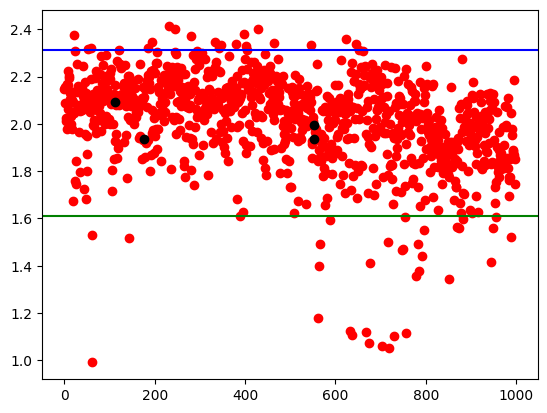

In [17]:
def plotmm(a,b,APs):
    ind = []
    randpep = []
    for i in range(800):
        c = random.randint(1,5555)
        ind.append(c)
    for i in range(len(ind)):
        randpep.append(APs.iloc[ind[i]-1])
    randpep = np.array(randpep)
    randmax = max(randpep)
    randmn = sum(randpep)/len(randpep)
    b_ind = []
    b_AP = []
    a_ind = []
    a_AP = []
    for i in range(len(b)-1):
        if b[i] not in a:
            b_ind.append(i)
            b_AP.append(APs.loc[b[i]])
        else:
            a_ind.append(i)
            a_AP.append(APs.loc[b[i]])
    print(b_ind)
    print(a_ind)
    x = np.array(b_ind)
    y = np.array(b_AP)
    plt.scatter(x,y,color='red')
    m = np.array(a_ind)
    n = np.array(a_AP)
    plt.scatter(m,n,color='black')
    plt.axhline(y=randmax,color='blue',label='randmax')
    plt.axhline(y=randmn,color='green',label='randmean')
    plt.show()
    return None
plotmm(a,b,APs)

In [18]:
print('Number of peptides explored = '+ str(len(b)))

Number of peptides explored = 1000


/var/folders/q9/dz7bsnq15t5crnph1_rcrhjr0000gn/T/ipykernel_1530/2147411487.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  poly.append(np.sum(coef[3-j]*(i**j) for j in range(len(coef))))


<function matplotlib.pyplot.show(close=None, block=None)>

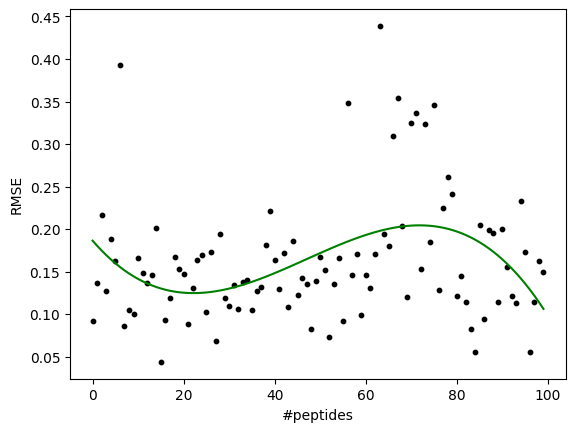

In [19]:
def bestfitpoly(r,ind):
    coef = np.polyfit(ind,r,3)
    poly = []
    for i in ind:
        poly.append(np.sum(coef[3-j]*(i**j) for j in range(len(coef))))
    return poly
plt.scatter(ind,r,color='black',s=10)
plt.plot(ind,bestfitpoly(r,ind),c = 'green')
plt.xlabel('#peptides')
plt.ylabel('RMSE')
plt.show

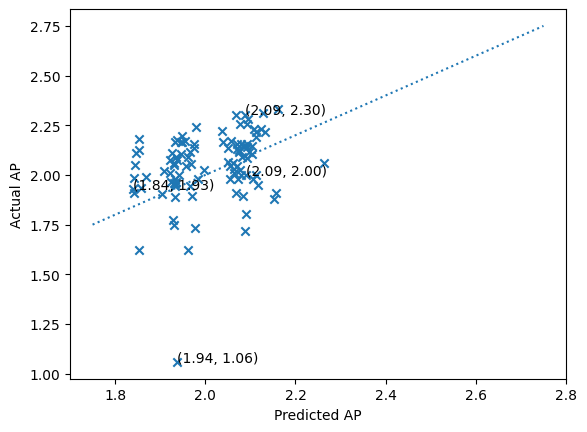

In [20]:
plt.scatter(pap,aap,marker='x')
c = 0
for xy in zip(pap, aap):
    c+=1
    if c%25 == 0:
        plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
plt.plot([1.75,2.75],[1.75,2.75],linestyle='dotted')
plt.xlabel('Predicted AP')
plt.ylabel('Actual AP')
plt.show()

But we find that at max only one peptide is found in the process for 80 iterations, whereas 20 peptides where found within 15 iterations in the paper.  

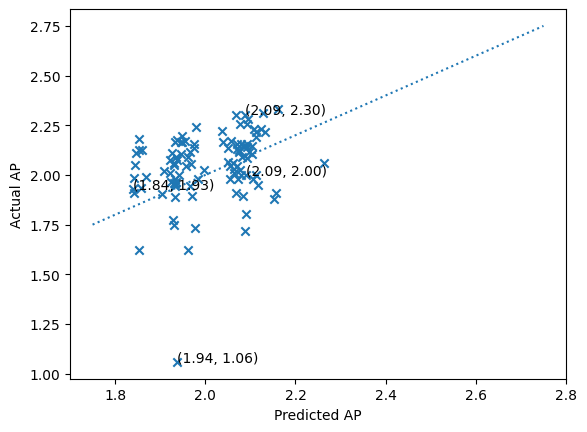

In [21]:
plt.scatter(pap1,aap1,marker='x')
c = 0
for xy in zip(pap1, aap1):
    c+=1
    if c%25 == 0:
        plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
plt.plot([1.75,2.75],[1.75,2.75],linestyle='dotted')
plt.xlabel('Predicted AP')
plt.ylabel('Actual AP')
plt.show()

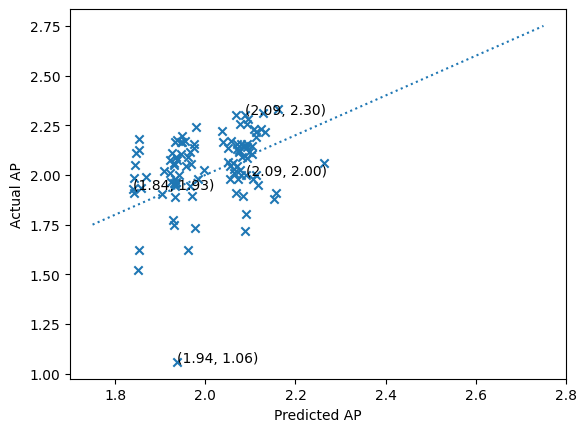

In [22]:
plt.scatter(pap2,aap2,marker='x')
c = 0
for xy in zip(pap2, aap2):
   c+=1
   if c%25 == 0:
      plt.annotate('(%.2f, %.2f)' % xy, xy=xy)
plt.plot([1.75,2.75],[1.75,2.75],linestyle='dotted')
plt.xlabel('Predicted AP')
plt.ylabel('Actual AP')
plt.show()

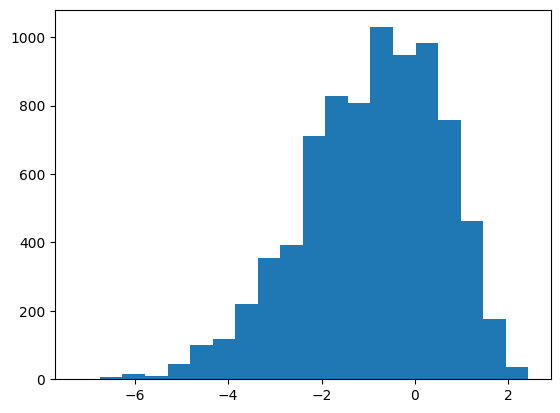

In [29]:
plt.hist(logparr, bins= 20)
plt.show()

In [30]:
np.min(logparr)

-7.23